# README

The intention of this project is to review and analyze 10-k financial statments from insurance companies using RAG.

This is going to be separated into 3 sections:
1. Extract most recent 10k Filings for TRV, PGR, CB, ALL using the SEC API (Limited by API Access)
2. Build RAG model to interpret filings
3. Front-end user interface to support interactions with the LLM.


# Extract Data

Difficulties with access to the SEC API caused issues with this section. This entire section can be skipped and the user can proceed to the Build RAG Model portion. Please ensure attached documents have been uploaded to folder named "insurance" in the same relative path /content/insurance.

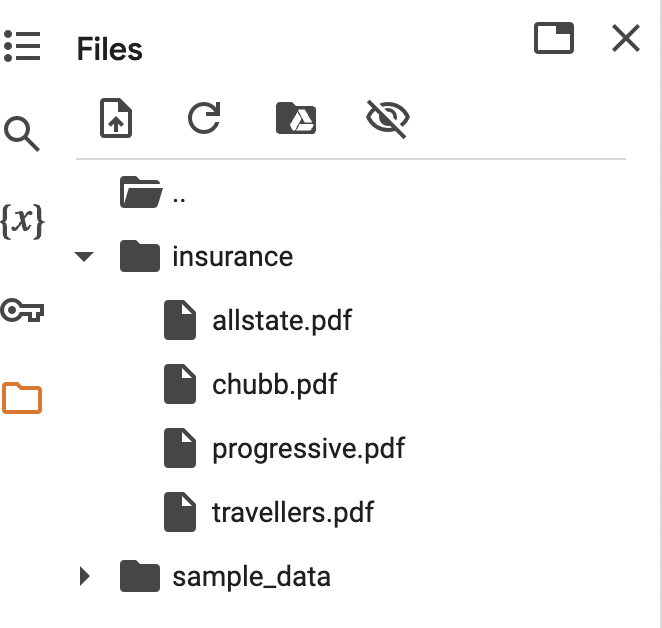

In [1]:
#!pip install sec-api
#Access SEC API to download latest findings for Travellers, Progressive, Chubb, and Allstate
#from sec_api import QueryApi

#queryApi = QueryApi(api_key="3a4ab73da6987d9673b92d1cc4142af1237cbfb82fb6d5d4829acae51a6cdebe")

#search_query = 'ticker:TRV,PGR,CB,ALL AND formType:"10-K"'

#parameters = {
#    "query": search_query,
#    "from": "0",
#    "size": "4",
#    "sort": [{"filedAt": {"order": "desc"}}],
#}

#response = queryApi.get_filings(parameters)

# Once complete, users could use the extractor API on the links found in this call to create the documents to analyze.
# I quickly ran out of free API calls and instead chose to create the functioning example using manually uploaded 10-ks

# Build RAG Model

In [2]:
# Install libraries for llama-index
%pip install llama-index
%pip install llama-index-llms-google-genai
%pip install llama-index-embeddings-google-genai


[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Add API key to access Gemini LLM and other google services as required
import os

GOOGLE_API_KEY = "<API KEY>"
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY


In [4]:
# Setup LLM for usage in the RAG model
from llama_index.llms.google_genai import GoogleGenAI

llm = GoogleGenAI(
    model="gemini-2.5-flash"

)

In [5]:
# Read in locally uploaded insurance 10-k documents from an "insurance" directory in the "content" directory
from llama_index.core import SimpleDirectoryReader

reader = SimpleDirectoryReader(input_dir="insurance")
documents = reader.load_data()

In [6]:
# Format documents for usage in the model
from llama_index.embeddings.google_genai import GoogleGenAIEmbedding
from llama_index.core import VectorStoreIndex
from llama_index.core import Settings

# Setup embedding model to be used in the indexing function
embed_model = GoogleGenAIEmbedding(
    model_name="text-embedding-004",
    embed_batch_size=100,
)

# Use basic index function supplied by Llamaindex to chunk and index the documents
# From_documents function chunks the supplied documents into nodes that can be interpreted by VectorStoreIndex
# VectorStoreIndex builds index in local memory
index = VectorStoreIndex.from_documents(documents, embed_model=embed_model)

2026-01-22 10:11:40,244 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/text-embedding-004:batchEmbedContents "HTTP/1.1 200 OK"
2026-01-22 10:11:41,484 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/text-embedding-004:batchEmbedContents "HTTP/1.1 200 OK"
2026-01-22 10:11:42,814 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/text-embedding-004:batchEmbedContents "HTTP/1.1 200 OK"
2026-01-22 10:11:43,943 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/text-embedding-004:batchEmbedContents "HTTP/1.1 200 OK"
2026-01-22 10:11:45,071 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/text-embedding-004:batchEmbedContents "HTTP/1.1 200 OK"
2026-01-22 10:11:46,299 - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/text-embedding-004:batchEmbedContents "HTTP/1.1 200 OK"
2026-01-22 10:11

In [7]:
# Create query engine using index and llm created earlier
query_engine = index.as_query_engine(llm=llm)

# Build Front-End Interface

This is a basic front-end interface to directly respond to a user query with an answer from the RAG model. As this current iteration is stateless, the answers reset when users ask a new question

In [8]:
%pip install ipywidgets


[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import ipywidgets as widgets
from IPython.display import display, HTML
import nest_asyncio
nest_asyncio.apply()


def process_query(query):
    # Call the RAG
    return f"{query_engine.query(query)}"

# Create input widget
query_input = widgets.Textarea(
    value='',
    placeholder='Enter your question here...',
    description='',
    layout=widgets.Layout(width='100%', height='100px')
)

# Create submit button
submit_button = widgets.Button(description='Submit', button_style='primary')

# Create output widget
output = widgets.Output()

# Function to handle submission
def on_submit(b):
    with output:
        output.clear_output()
        query = query_input.value.strip()
        if query:
            answer = process_query(query)
            # User query bubble (right)
            display(HTML(f'''
                <div style="display: flex; justify-content: flex-end; margin: 10px;">
                    <div style="background-color: #e1f5fe; padding: 10px; border-radius: 15px; max-width: 70%;">
                        <strong>You:</strong> {query}
                    </div>
                </div>
            '''))
            # Machine answer bubble (left)
            display(HTML(f'''
                <div style="display: flex; justify-content: flex-start; margin: 10px;">
                    <div style="background-color: #f1f8e9; padding: 10px; border-radius: 15px; max-width: 70%;">
                        <strong>Assistant:</strong> {answer}
                    </div>
                </div>
            '''))
        query_input.value = ''  # Clear input after submission

submit_button.on_click(on_submit)

# Display the interface
display(query_input, submit_button, output)